# Sales Forecasting -  Data exploration

### Import libraries and raw data

In [208]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import sys
import statsmodels.api as sm
sys.path.insert(0, '../utils/')
import functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [209]:
df = pd.read_excel("../data/Superstore.xls")

In [210]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [211]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Simplify Time Series Data
To simplify the analysis and focus on the core objective of sales forecasting, we will restrict the dataset to a subset of variables: Order Date, Category, and Sales.
These features capture the essential temporal and categorical structure needed to model sales trends over time while reducing noise from unrelated variables.

In [212]:
df = df[['Order Date', 'Category', 'Sales']]
df

,Order Date,Category,Sales
0,2013-11-09,Furniture,261.9600
1,2013-11-09,Furniture,731.9400
2,2013-06-13,Office Supplies,14.6200
3,2012-10-11,Furniture,957.5775
4,2012-10-11,Office Supplies,22.3680
...,...,...,...
9989,2011-01-22,Furniture,25.2480
9990,2014-02-27,Furniture,91.9600
9991,2014-02-27,Technology,258.5760
9992,2014-02-27,Office Supplies,29.6000


Sales will be aggregated by day and product category to generate a clean time series for each category, which can then be used to train forecasting models.

In [213]:
df_group = df.groupby(['Order Date', 'Category'])['Sales'].sum().reset_index()
df_group

,Order Date,Category,Sales
0,2011-01-04,Office Supplies,16.448
1,2011-01-05,Office Supplies,288.060
2,2011-01-06,Office Supplies,19.536
3,2011-01-07,Furniture,2573.820
4,2011-01-07,Office Supplies,685.340
...,...,...,...
2859,2014-12-30,Office Supplies,282.440
2860,2014-12-30,Technology,302.376
2861,2014-12-31,Furniture,323.136
2862,2014-12-31,Office Supplies,299.724


In [214]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  2864 non-null   datetime64[ns]
 1   Category    2864 non-null   object        
 2   Sales       2864 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.2+ KB


In [215]:
print('\n Unique categories:')
print(df_group['Category'].unique())


 Unique categories:
['Office Supplies' 'Furniture' 'Technology']


### Setting index using date column

In [216]:
df_group.set_index('Order Date', inplace=True)
df_group

,Category,Sales
Order Date,,
2011-01-04,Office Supplies,16.448
2011-01-05,Office Supplies,288.060
2011-01-06,Office Supplies,19.536
2011-01-07,Furniture,2573.820
2011-01-07,Office Supplies,685.340
...,...,...
2014-12-30,Office Supplies,282.440
2014-12-30,Technology,302.376
2014-12-31,Furniture,323.136


# Standardizing
we need to ensure:
- No duplicate index values 
- No missing index values 

In [217]:
df_group.reset_index(inplace=True)
# Note if we didn't reset the index, we could use index=None below
sales_pivot = df_group.pivot(index='Order Date', columns='Category', values='Sales')
sales_pivot.head()

Category,Furniture,Office Supplies,Technology
Order Date,,,
2011-01-04,NaN,16.448,NaN
2011-01-05,NaN,288.060,NaN
2011-01-06,NaN,19.536,NaN
2011-01-07,2573.820,685.340,1147.94
2011-01-08,76.728,10.430,NaN


In [218]:
sales = df_group.set_index(['Order Date', 'Category']).unstack('Category').fillna(0)

In [219]:
sales.columns = sales.columns.levels[1].rename(None)
sales.head()

,Furniture,Office Supplies,Technology
Order Date,,,
2011-01-04,0.000,16.448,0.00
2011-01-05,0.000,288.060,0.00
2011-01-06,0.000,19.536,0.00
2011-01-07,2573.820,685.340,1147.94
2011-01-08,76.728,10.430,0.00


In [220]:
len(sales.index.unique())

1238

Checking for missing days

In [221]:
date_range = sales.index.max() - sales.index.min()
date_range

Timedelta('1457 days 00:00:00')

There are more days in the data range than in our dataset.

In [222]:
new_index = pd.date_range(sales.index.min(), sales.index.max())
sales_new = sales.reindex(new_index, fill_value=0)
sales_new.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-08', '2011-01-09', '2011-01-10', '2011-01-11',
               '2011-01-12', '2011-01-13',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=1458, freq='D')

In [223]:
sales_new

,Furniture,Office Supplies,Technology
2011-01-04,0.0000,16.448,0.000
2011-01-05,0.0000,288.060,0.000
2011-01-06,0.0000,19.536,0.000
2011-01-07,2573.8200,685.340,1147.940
2011-01-08,76.7280,10.430,0.000
...,...,...,...
2014-12-27,0.0000,814.594,0.000
2014-12-28,0.0000,13.248,164.388
2014-12-29,551.2568,1091.244,14.850
2014-12-30,2330.7180,282.440,302.376


In [224]:
sales_new.to_csv("../data/superstore_dataset_clean.csv")

## Visualizations

In [225]:
sales_weekly = sales_new.resample('W').sum()
sales_monthly = sales_new.resample('ME').sum()
sales_quarterly = sales_new.resample('QE').sum()
sales_annual = sales_new.resample('YE').sum()


<Axes: title={'center': 'Weekly Sales'}>

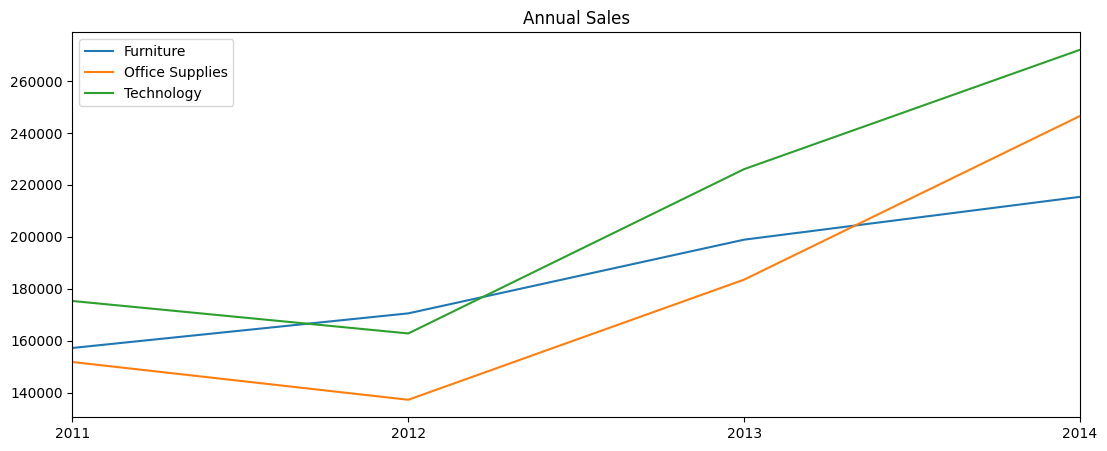

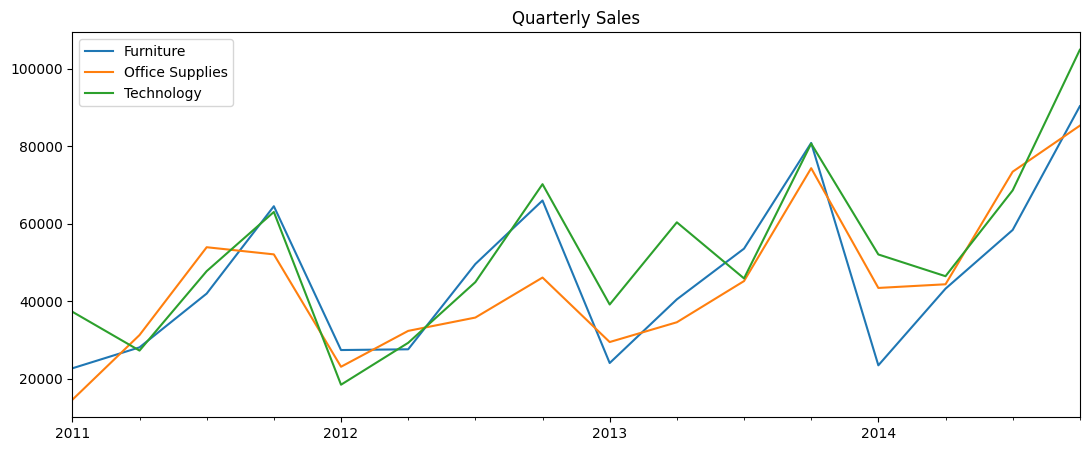

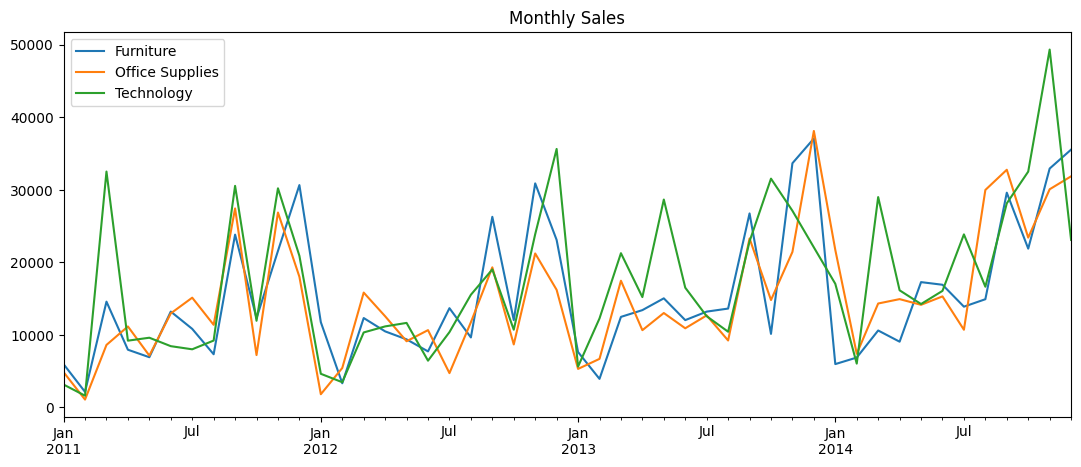

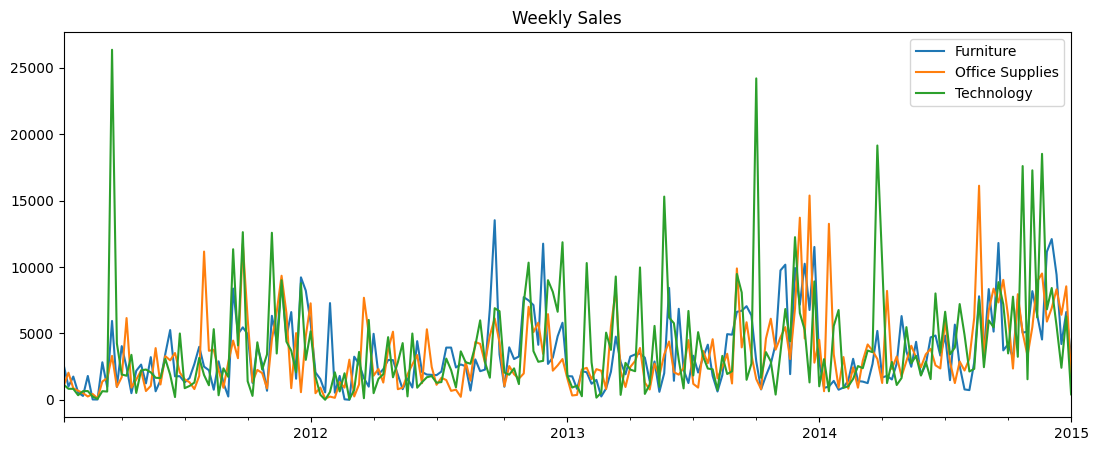

In [226]:
plotsize = (13, 5)
sales_annual.plot(figsize=plotsize, title='Annual Sales')
sales_quarterly.plot(figsize=plotsize, title='Quarterly Sales')
sales_monthly.plot(figsize=plotsize, title='Monthly Sales')
sales_weekly.plot(figsize=plotsize, title='Weekly Sales')


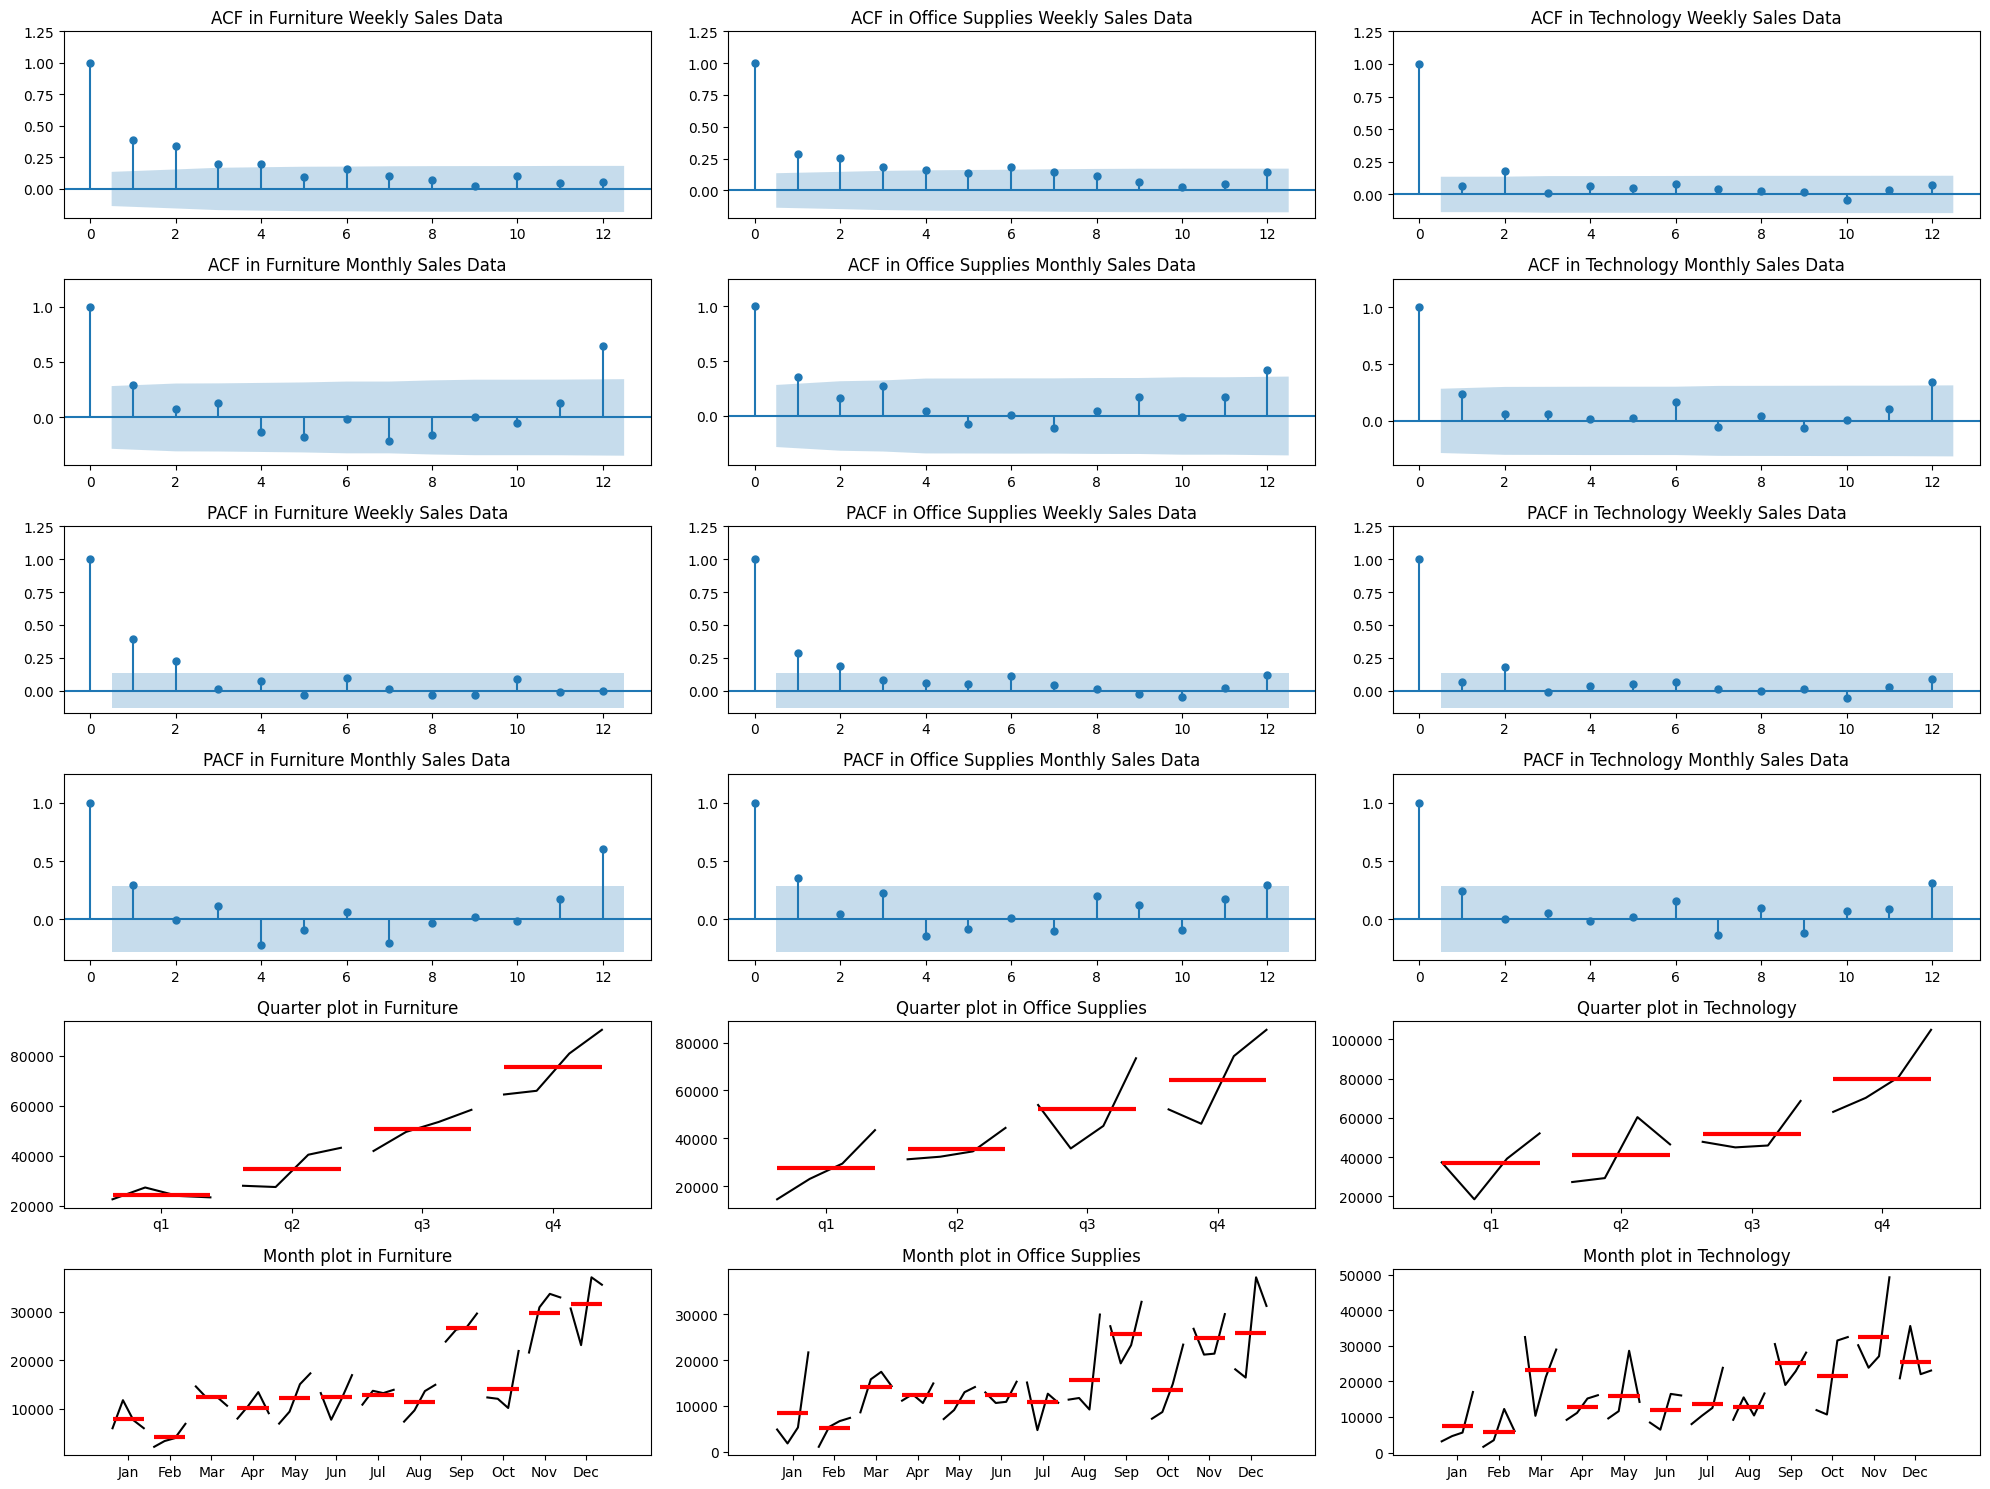

In [227]:
fig, axes = plt.subplots(6,3, figsize=(20,15))
for i, cat in enumerate(list(sales_new.columns)):
    plot_acf(sales_weekly[cat], ax=axes[0,i], lags=12, title=f'ACF in {cat} Weekly Sales Data', auto_ylims=[-0.50,1.1])
    plot_acf(sales_monthly[cat], ax=axes[1,i], lags=12, title=f'ACF in {cat} Monthly Sales Data', auto_ylims=[-0.50,1.1])
    plot_pacf(sales_weekly[cat], ax=axes[2,i], lags=12, title=f'PACF in {cat} Weekly Sales Data', auto_ylims=[-0.50,1.1])
    plot_pacf(sales_monthly[cat], ax=axes[3,i], lags=12, title=f'PACF in {cat} Monthly Sales Data', auto_ylims=[-0.50,1.1])
    quarter_plot(sales_quarterly[cat], ax=axes[4,i])
    axes[4,i].set_title(f'Quarter plot in {cat}')
    month_plot(sales_monthly[cat],ax=axes[5,i])
    axes[5,i].set_title(f'Month plot in {cat}')
plt.tight_layout()

All three product categories (Furniture, Office Supplies, and Technology) show clear annual seasonality, with consistent sales peaks in November - December, as seen in monthly sales plots and strong autocorrelation at lag 12. Additionally, there is an upward trend in sales throughout the year, especially visible in quarterly aggregations. These patterns indicate that time series models should include both trend and seasonal components


## Monthly Sales Forecasting

In this project, we will analyze the monthly sales database and forecast future monthly sales.

In [228]:
sales_monthly.to_csv('../data/monthly_sales.csv')

In [229]:
df = pd.read_csv('../data/monthly_sales.csv',index_col=0)
df.index = pd.to_datetime(df.index)

In [230]:
df.head()

,Furniture,Office Supplies,Technology
2011-01-31,5951.859,4851.080,3143.290
2011-02-28,2130.324,1071.724,1608.510
2011-03-31,14573.956,8605.879,32511.174
2011-04-30,7944.837,11155.074,9195.434
2011-05-31,6912.787,7135.624,9599.876


In [231]:
df.describe()

,Furniture,Office Supplies,Technology
count,48.000000,48.000000,48.000000
mean,15458.329069,14980.146500,17419.875687
std,9181.057065,8596.844978,10254.518007
min,2130.324000,1071.724000,1608.510000
25%,9294.394600,9003.654500,10145.922500
50%,12836.203500,12979.967500,15792.074000
75%,21644.671575,19783.857750,23854.188750
max,37068.685000,38112.154000,49329.553000


Text(0.5, 58.7222222222222, 'Month')

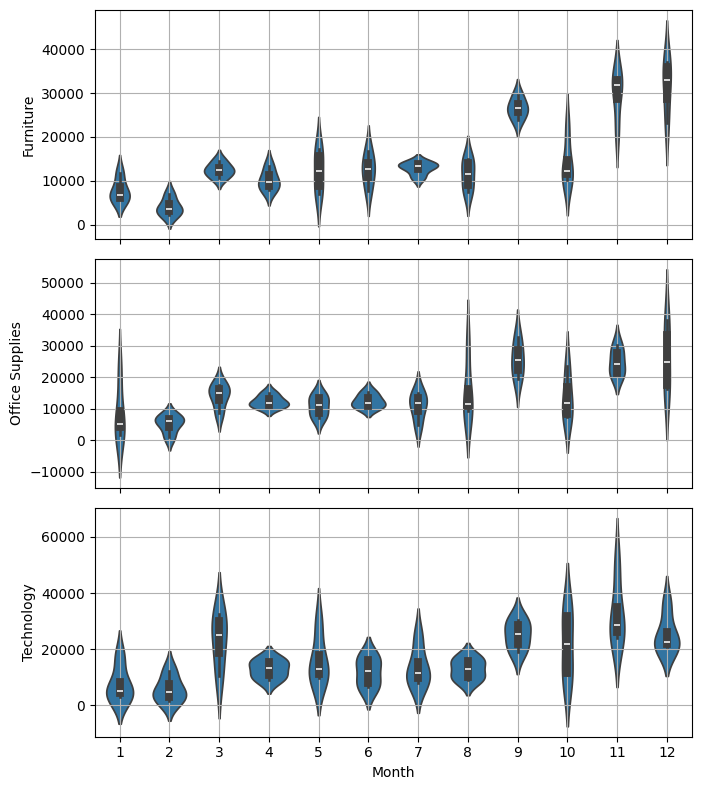

In [232]:
fig, axs = plt.subplots(3,1, figsize=(7,8), sharex=True)
for i, cat in enumerate(list(df.columns)):
    sns.violinplot(x=df.index.month, y=df[cat],ax=axs[i])
    axs[i].grid()
plt.tight_layout()
axs[2].set_xlabel('Month')

## Trasformation
The variance does not seem to stay constant throughout, so will apply log-transformation

In [233]:
for col in list(sales_monthly.columns):
    sales_monthly[col+'_log'] = np.log1p(sales_monthly[col])

In [235]:
sales_monthly.head()

,Furniture,Office Supplies,Technology,Furniture_log,Office Supplies_log,Technology_log
2011-01-31,5951.859,4851.080,3143.290,8.691627,8.487163,8.053343
2011-02-28,2130.324,1071.724,1608.510,7.664499,6.977956,7.383685
2011-03-31,14573.956,8605.879,32511.174,9.587060,9.060317,10.389370
2011-04-30,7944.837,11155.074,9195.434,8.980403,9.319739,9.126571
2011-05-31,6912.787,7135.624,9599.876,8.841273,8.872995,9.169610


In [245]:
sales_monthly.to_csv('../data/monthly_sales.csv')

## Decomposition

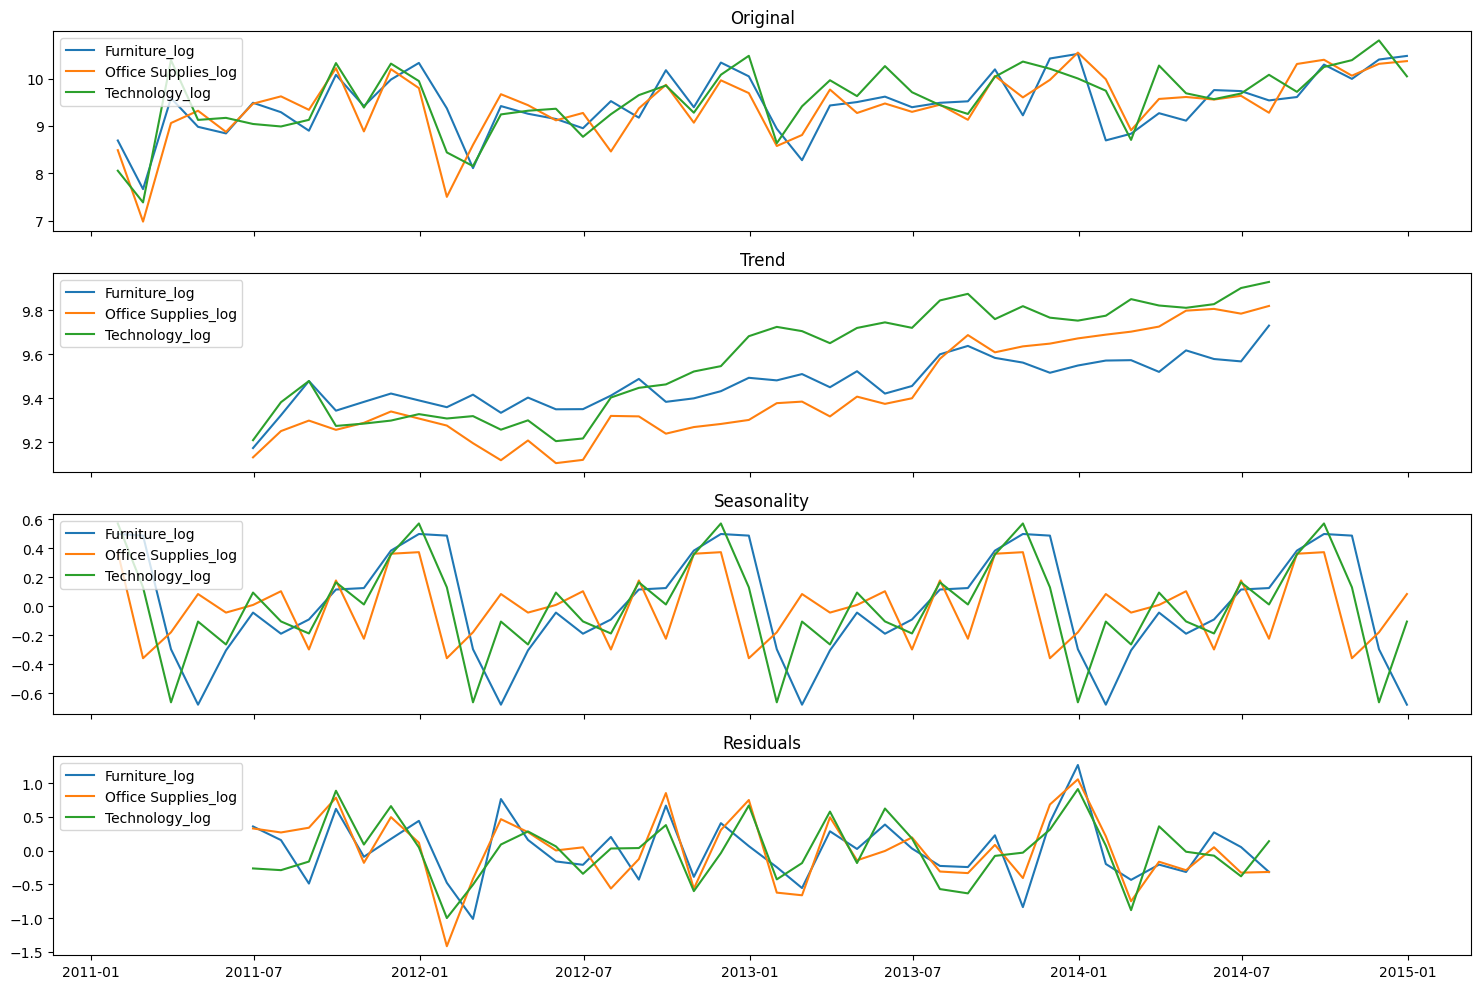

In [239]:

categories = ['Furniture_log', 'Office Supplies_log', 'Technology_log']
period = 11

trends = {}
seasonals = {}
residuals = {}

# Descomponer cada categoría
for cat in categories:
    decomposition = seasonal_decompose(sales_monthly[cat], model='additive', period=period)
    trends[cat] = decomposition.trend
    seasonals[cat] = decomposition.seasonal
    residuals[cat] = decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 10))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for cat, color in zip(categories, colors):
    axes[0].plot(sales_monthly[cat], label=cat, color=color)
axes[0].set_title('Original')
axes[0].legend(loc='upper left')

# Trend
for cat, color in zip(categories, colors):
    axes[1].plot(trends[cat], label=cat, color=color)
axes[1].set_title('Trend')
axes[1].legend(loc='upper left')

# Seasonality
for cat, color in zip(categories, colors):
    axes[2].plot(seasonals[cat], label=cat, color=color)
axes[2].set_title('Seasonality')
axes[2].legend(loc='upper left')

# Residuals
for cat, color in zip(categories, colors):
    axes[3].plot(residuals[cat], label=cat, color=color)
axes[3].set_title('Residuals')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

Trend: All three categories (Furniture, Office Supplies, Technology) show a clear upward trend over time, with Technology increasing the fastest.

Seasonality: Furniture and Technology display a well-defined and consistent seasonal pattern.

Office Supplies shows a weaker and less regular seasonality.

Residuals: Random and reasonably centered around zero

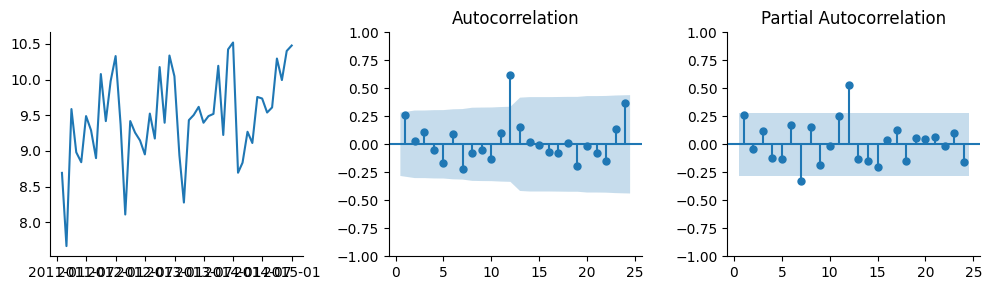

In [241]:
functions.plots(sales_monthly['Furniture_log'], lags=24)

The time series shows a clear upward trend, indicating non-stationarity in its mean. Additionally, the PACF reveals a strong spike at lag 12, suggesting the presence of annual seasonality. The ACF does not decay quickly, further supporting the presence of both trend and seasonality. These observations imply that the series likely requires both regular and seasonal differencing to achieve stationarity. 

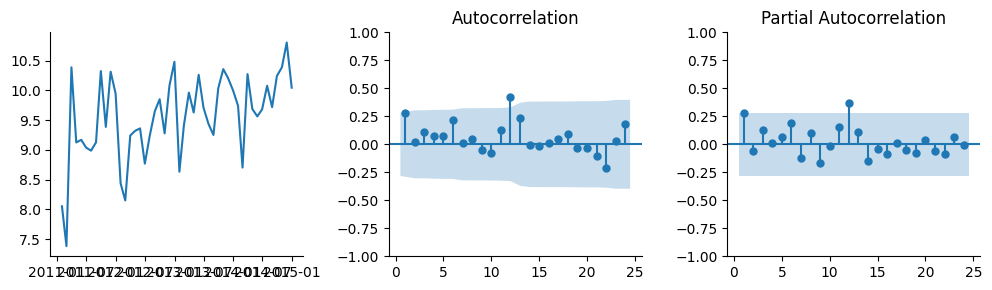

In [242]:
functions.plots(sales_monthly['Technology_log'], lags=24)

The Technology time series shows a clear upward trend and moderate seasonal peaks, indicating non-stationarity in the mean. The ACF displays  a noticeable peak at lag 12, which points to a strong yearly seasonal pattern. The PACF also shows a significant spike at lag 12 and some short-term dependencies (e.g., lag 1). These observations suggest that the series likely requires regular and seasonal differencing to achieve stationarity. 

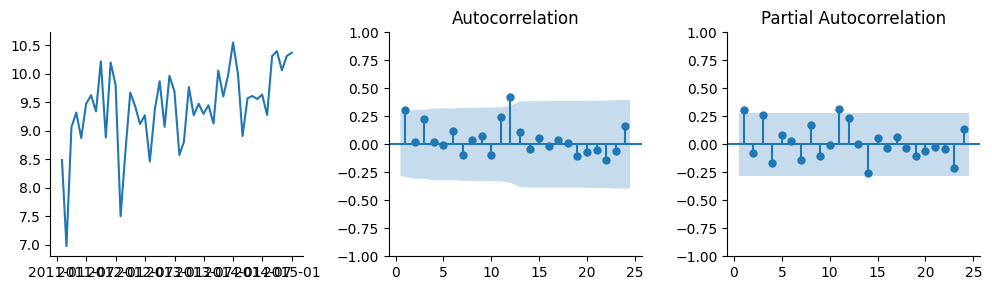

In [243]:
functions.plots(sales_monthly['Office Supplies_log'], lags=24)

The Office Supplies series also exhibits a noticeable upward trend, indicating non-stationarity, though the seasonality appears weaker. The ACF shows mild autocorrelation with a possible seasonal peak around lag 12. The PACF has a small spike at lag 1 and another minor one at lag 12. Overall, the seasonal structure is less clear, and the series seems to be more irregular and volatile, which may reduce the effectiveness of seasonal models. 